<a href="https://colab.research.google.com/github/Shashank-Girish/FinancialNewsSentimentAnalysis/blob/main/ML_Minor_FinNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment tensorflow datasets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!sudo pip3 install keras

In [3]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from datasets import Dataset
import seaborn as sns
from google.colab import drive
from wordcloud import WordCloud
import re
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset (adjust the file path as needed)
file_path = '/content/drive/My Drive/IndianFinancialNews.csv'
df = pd.read_csv(file_path)

# Check the dataset structure
df.head()


Mounted at /content/drive


,Unnamed: 0,Date,Title,Description
0,0,"May 26, 2020, Tuesday","ATMs to become virtual bank branches, accept d...","Close to 14.6 per cent (or 35,000) of the 240,..."
1,1,"May 26, 2020, Tuesday",IDFC First Bank seniors to forgo 65% of bonus ...,"V Vaidyanathan, managing director and chief ex..."
2,2,"May 25, 2020, Monday","Huge scam in YES Bank for many years, says Enf...",Rana Kapoor's wife also charged with abetting ...
3,3,"May 24, 2020, Sunday","Bank of Maharashtra sanctioned Rs 2,789 cr in ...",The bank said it was now gearing up to extend ...
4,4,"May 23, 2020, Saturday",DCB Bank's profit before tax declines 37.6% to...,Net profit for the financial year ended March ...


In [5]:
# Remove rows with missing values in relevant columns
df.dropna(subset=['Title', 'Description'], inplace=True)

# Define a function to clean text (remove URLs, punctuation, etc.)
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning to 'title' and 'description'
df['cleaned_description'] = df['Description'].apply(clean_text)

# Check cleaned data
df[['Description', 'cleaned_description']].head()


,Description,cleaned_description
0,"Close to 14.6 per cent (or 35,000) of the 240,...",close to 146 per cent or 35000 of the 240000 a...
1,"V Vaidyanathan, managing director and chief ex...",v vaidyanathan managing director and chief exe...
2,Rana Kapoor's wife also charged with abetting ...,rana kapoors wife also charged with abetting c...
3,The bank said it was now gearing up to extend ...,the bank said it was now gearing up to extend ...
4,Net profit for the financial year ended March ...,net profit for the financial year ended march ...


In [6]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function for VADER sentiment
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    return 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral'

# Define function for TextBlob sentiment
def get_textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    return 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'

# Apply sentiment functions to 'cleaned_description' column
df['vader_sentiment'] = df['cleaned_description'].apply(get_vader_sentiment)
df['textblob_sentiment'] = df['cleaned_description'].apply(get_textblob_sentiment)

# Filter rows where VADER and TextBlob sentiments match
df = df[df['vader_sentiment'] == df['textblob_sentiment']].copy()

# Check the resulting dataframe
df[['cleaned_description', 'vader_sentiment', 'textblob_sentiment']].head()


,cleaned_description,vader_sentiment,textblob_sentiment
0,close to 146 per cent or 35000 of the 240000 a...,neutral,neutral
6,hdfc bank cuts base rate by 55 bps sbi calls a...,negative,negative
11,enquiries for fresh loans see uptick,positive,positive
15,loans sanctioned by public sector banks psbs a...,neutral,neutral
16,senior bank executives said the indian banks a...,neutral,neutral


In [7]:
device = 0 if torch.cuda.is_available() else -1

finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Initialize RoBERTa sentiment analysis pipeline
finbert_pipeline = pipeline("sentiment-analysis", model=finbert_model, tokenizer=tokenizer, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
hf_dataset = Dataset.from_pandas(df)

In [9]:
# Define a batch processing function for sentiment analysis
def batch_sentiment_analysis(batch):
    results = finbert_pipeline(batch['cleaned_description'])
    # Extract just the labels
    batch['finbert_sentiment'] = [result['label'].lower() for result in results]
    return batch

# Apply the function to the entire dataset with batch processing
hf_dataset = hf_dataset.map(batch_sentiment_analysis, batched=True, batch_size=16)  # Adjust batch_size as needed

Map:   0%|          | 0/22581 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [10]:
# Convert back to DataFrame after sentiment analysis
df = hf_dataset.to_pandas()

df.head()

,Unnamed: 0,Date,Title,Description,cleaned_description,vader_sentiment,textblob_sentiment,__index_level_0__,finbert_sentiment
0,0,"May 26, 2020, Tuesday","ATMs to become virtual bank branches, accept d...","Close to 14.6 per cent (or 35,000) of the 240,...",close to 146 per cent or 35000 of the 240000 a...,neutral,neutral,0,neutral
1,6,"May 22, 2020, Friday","Retail, MSME loans to get cheaper as RBI cuts ...",HDFC Bank cuts base rate by 55 bps; SBI calls ...,hdfc bank cuts base rate by 55 bps sbi calls a...,negative,negative,6,neutral
2,11,"May 22, 2020, Friday",Lockdown 4.0: Normalcy returning for shadow le...,Enquiries for fresh loans see uptick,enquiries for fresh loans see uptick,positive,positive,11,positive
3,15,"May 21, 2020, Thursday",Bank credit growth slowed in Dec quarter on mu...,Loans sanctioned by public sector banks (PSBs)...,loans sanctioned by public sector banks psbs a...,neutral,neutral,15,neutral
4,16,"May 21, 2020, Thursday","Covid-19 crisis: Banks seek relaxed NPA norms,...",Senior bank executives said the Indian Banks' ...,senior bank executives said the indian banks a...,neutral,neutral,16,neutral


In [11]:
# Split the data into features (X) and target (y) using RoBERTa sentiment labels
X = df['cleaned_description']
y = df['vader_sentiment']

# Convert text data to numerical data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [12]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_nb = nb_classifier.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8472437458490149
Classification Report:
               precision    recall  f1-score   support

    negative       0.98      0.34      0.51       567
     neutral       0.86      0.96      0.91      2404
    positive       0.81      0.86      0.84      1546

    accuracy                           0.85      4517
   macro avg       0.88      0.72      0.75      4517
weighted avg       0.86      0.85      0.83      4517



In [13]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_rf = rf_classifier.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9094531768873146
Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.66      0.78       567
     neutral       0.91      0.99      0.94      2404
    positive       0.91      0.88      0.89      1546

    accuracy                           0.91      4517
   macro avg       0.92      0.84      0.87      4517
weighted avg       0.91      0.91      0.91      4517



In [14]:
# Train Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=200)
lr_classifier.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_lr = lr_classifier.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.913438122647775
Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.69      0.80       567
     neutral       0.89      0.99      0.94      2404
    positive       0.95      0.88      0.91      1546

    accuracy                           0.91      4517
   macro avg       0.93      0.85      0.88      4517
weighted avg       0.92      0.91      0.91      4517



In [15]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=200)

# ----> Convert sentiment labels to numerical representation
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Define mapping
y_numeric = y.map(sentiment_mapping)

# Train-test split for RNN
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_padded, y_numeric, test_size=0.2, random_state=42)

# Build an LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=200),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_rnn, y_train_rnn, epochs=5, batch_size=32, validation_data=(X_test_rnn, y_test_rnn))

# Evaluate the RNN model
loss, accuracy = model.evaluate(X_test_rnn, y_test_rnn)
print("RNN Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 377ms/step - accuracy: 0.6931 - loss: 0.7169 - val_accuracy: 0.9411 - val_loss: 0.1985
Epoch 2/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 246s 358ms/step - accuracy: 0.9635 - loss: 0.1283 - val_accuracy: 0.9595 - val_loss: 0.1403
Epoch 3/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 200s 355ms/step - accuracy: 0.9822 - loss: 0.0657 - val_accuracy: 0.9615 - val_loss: 0.1459
Epoch 4/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 205s 360ms/step - accuracy: 0.9881 - loss: 0.0445 - val_accuracy: 0.9546 - val_loss: 0.1714
Epoch 5/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 262s 361ms/step - accuracy: 0.9921 - loss: 0.0325 - val_accuracy: 0.9602 - val_loss: 0.1572
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9620 - loss: 0.1459
RNN Model Accuracy: 0.9601505398750305


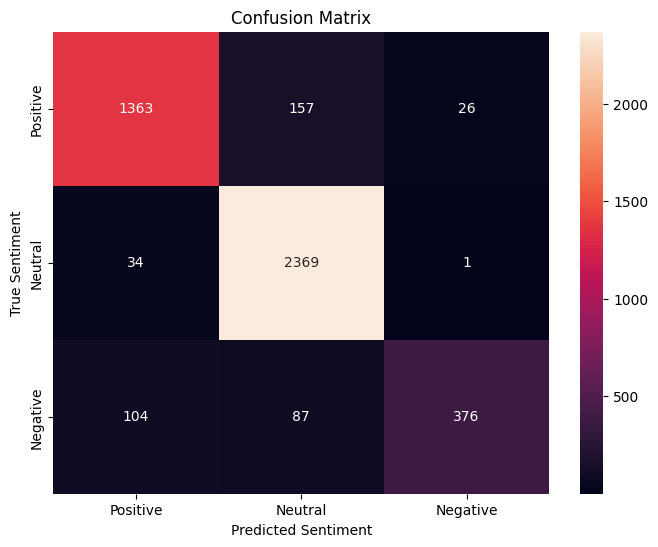

In [16]:

cm = confusion_matrix(y_test, y_pred_rf, labels=['positive', 'neutral', 'negative'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for Random Forest')
plt.show()


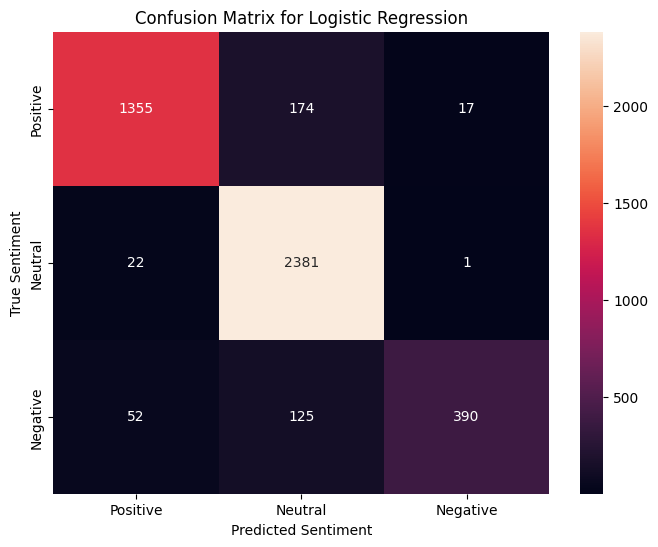

In [18]:

cm = confusion_matrix(y_test, y_pred_lr, labels=['positive', 'neutral', 'negative'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

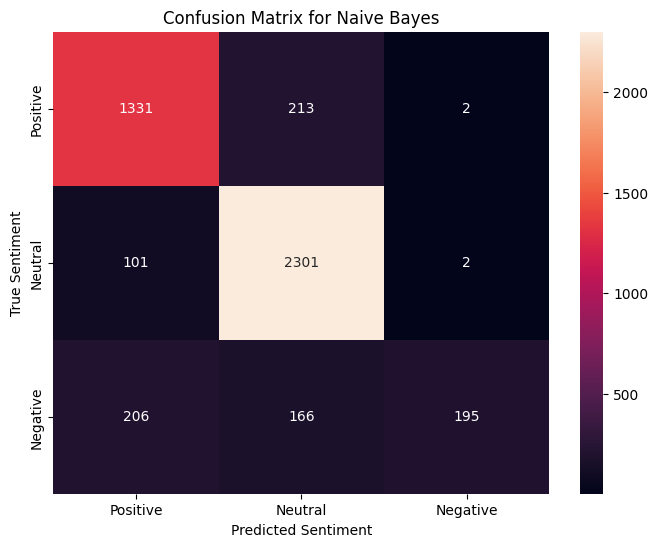

In [19]:

cm = confusion_matrix(y_test, y_pred_nb, labels=['positive', 'neutral', 'negative'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

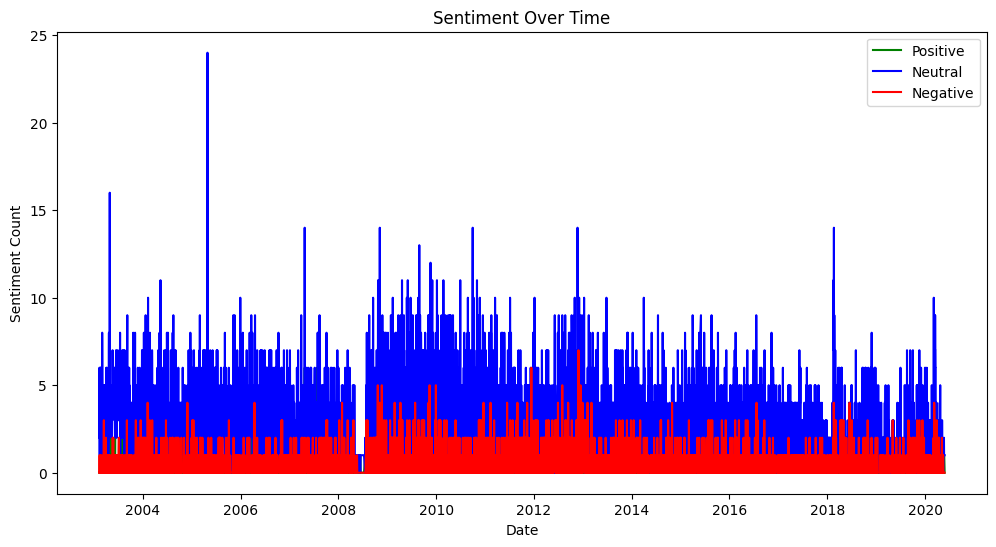

In [20]:
# Step 1: Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Group by 'Date' and 'finbert_sentiment' to get sentiment counts per day
sentiment_counts = df.groupby(['Date', 'finbert_sentiment']).size().reset_index(name='count')

# Step 3: Pivot the data to have each sentiment as a separate column
sentiment_pivot = sentiment_counts.pivot(index='Date', columns='finbert_sentiment', values='count').fillna(0)

# Step 4: Plot the time series using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(sentiment_pivot.index, sentiment_pivot['positive'], label='Positive', color='green')
plt.plot(sentiment_pivot.index, sentiment_pivot['neutral'], label='Neutral', color='blue')
plt.plot(sentiment_pivot.index, sentiment_pivot['negative'], label='Negative', color='red')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.legend()
plt.show()

In [22]:
# Step 5: Reset index to prepare for Plotly plotting
sentiment_pivot = sentiment_pivot.reset_index()

# Step 6: Use Plotly to create an interactive line plot
fig = px.line(sentiment_pivot, x='Date', y=['positive', 'neutral', 'negative'],
              labels={'value': 'Sentiment Count', 'Date': 'Date'},
              title='Sentiment Over Time')
fig.update_layout(yaxis_title="Sentiment Count", xaxis_title="Date")
fig.show()


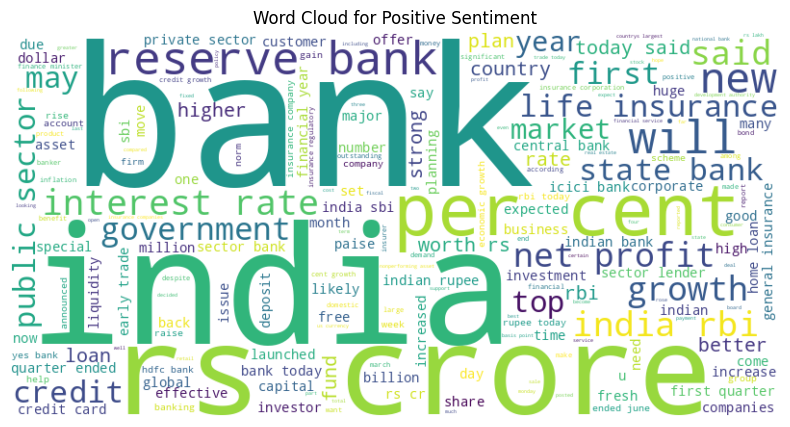

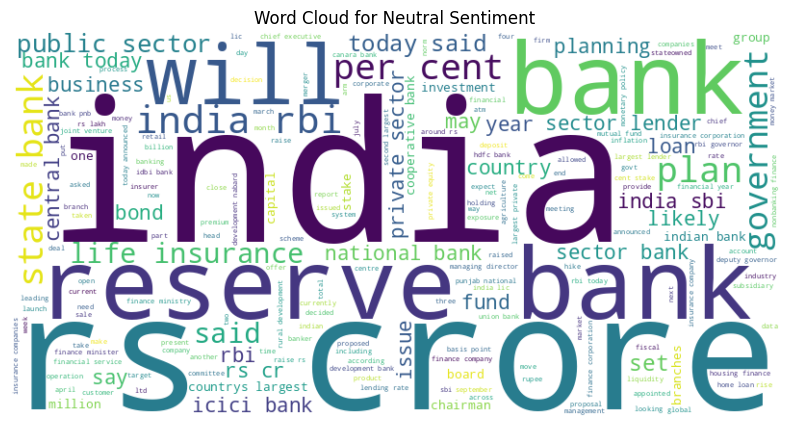

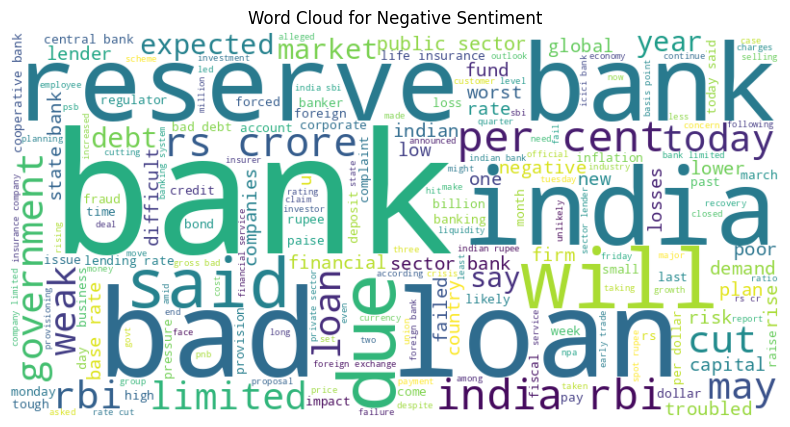

In [17]:
# Generate word clouds for each sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    text = " ".join(description for description in df[df['vader_sentiment'] == sentiment]['cleaned_description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.show()
